In [1]:
# This notebook is for creating random monotonic models of Uranus.
# The only constraints on the model are the that innermost shell has a temperature less than 50K
# and that the temperature/density/composition/pressure are monotonically decreasing as the radius increases.

In [2]:
import random
import numpy           as np
from matplotlib        import pyplot as plt
from matplotlib.pyplot import figure, legend

import lib.constants   as constants
import lib.profile     as profile
import lib.temperature as temperature
import lib.mc_interior as mc_interior
EPS = 1

In [3]:
# Set for Uranus
mass = constants.URANUS.mass
moment_ratio = constants.URANUS.moment_ratio
radius = constants.URANUS.radius
num_shells = 100


In [4]:
SMOOTH = 201
USE_IRON = True
MIN_TEMP = 0
MAX_TEMP = 50000

In [5]:
# Create a bunch of random models.
catalog = temperature.iron_sio2_water_env_catalog() if USE_IRON else temperature.sio2_water_env_catalog()
def best_model(seed=None, catalog=catalog, min_temp=MIN_TEMP, max_temp=MAX_TEMP, smooth=SMOOTH, full_model=False):
    # First do the inverse
    seed, i_m, inner_temp, i_count = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                                                max_temp=min_temp,
                                                                seed=seed,
                                                                temperature_catalog=catalog,
                                                                full_model=True,
                                                                smooth=smooth,
                                                                inverse=True)
    retval = [seed]
    if i_m is None:
        inner_temp = max_temp
        retval.append((None, None, None))
    
    # Otherwise, need to generate the forward model.
    else:
        retval.append((i_m.get_mix_ratios(), inner_temp, i_count))
    seed, f_m, inner_temp, f_count = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                                                max_temp=max(max_temp, inner_temp+EPS),
                                                                seed=seed,
                                                                temperature_catalog=catalog,
                                                                full_model=True,
                                                                smooth=smooth,
                                                                inverse=False)
    if f_m is None:
        retval.append((None, None, None))
    else:
        retval.append((f_m.get_mix_ratios(), inner_temp, f_count))
        
    if i_m is None or f_m is None:
        retval.append((None, None, None))
        return retval
    
    # Now do the both_ends model
    cf = f_m.get_composition()
    ci = i_m.get_composition()
    cc = [x if abs(x) > abs(y) else y for (x,y) in zip(cf,ci)]
    mix = []
    for comp in cc:
        mix.append(catalog.composition_to_mix(comp))
                      
    both =  mc_interior.MCInterior(f_m.get_radii(), f_m.get_densities(),mix, catalog) 
    retval.append((both.get_mix_ratios(), both.get_inner_temp(), max(f_count, i_count)))
    
    if full_model:
        # Plot density
        both.plot_densities()
        figure()

        # Plot pressure
        both.plot_pressure()
        figure()

        # Plot temperature
        both.plot_temp(catalog)
        figure()

        # Plot composition
        both.plot_mix()
        figure()

        f_m.plot_composition("forward composition")
        i_m.plot_composition("inverse composition")
        both.plot_composition("both composition")
        figure()
        # plot temp profiles
        m_profile = profile.TemperatureProfile(catalog, both)
        m_profile.plot_temperature_profile()

    return retval
    
def save_models(filename, model_list):
    fp = open(filename, "w")
    fp.write("seed, inv_env, inv_water, inv_sio2, inv_iron, inv_temp, inv_count, fwd_env, fwd_water, fwd_sio2, fwd_iron, fwd_temp, fwd_count, bth_env, bth_water, bth_sio2, bth_iron, bth_temp, bth_count\n")
    for model in model_list:
        seed, inv, fwd, bth = model
        def to_list(x):
            if x[0] is None:
                return [None, None, None, x[1], x[2]]
            else:
                return x[0] + [x[1], x[2]]
        line = [seed]+to_list(inv)+to_list(fwd)+to_list(bth)
        #print(line)
        fp.write(",".join([str(x) for x in line])+'\n')
    fp.close()

In [6]:
good_models = []
bad_models = []
for i in range(1000):
    retval = best_model(max_temp=MAX_TEMP)
    seed, inv, fwd, bth = retval
    if inv[0] is None and fwd[0] is None and bth[0] is None:
        bad_models.append((seed, inv, fwd, bth))
    else:
        good_models.append((seed, inv, fwd, bth))

In [7]:
list(enumerate(good_models))

[]

In [8]:
save_models("test.csv", good_models)

[0.709555096,
 ([0.17, 0.51, 0.31, 0.0], 59778.60381588882, 0),
 ([0.16, 0.52, 0.31, 0.0], 59779.64569466804, 0),
 ([0.17, 0.51, 0.31, 0.0], 59779.64569466804, 0)]

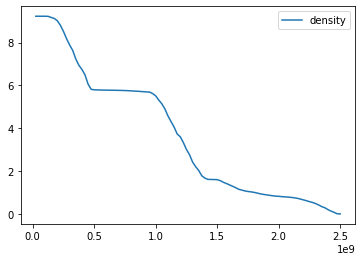

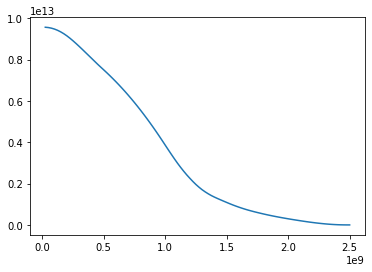

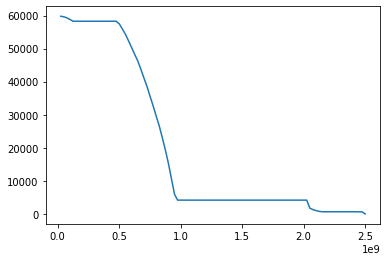

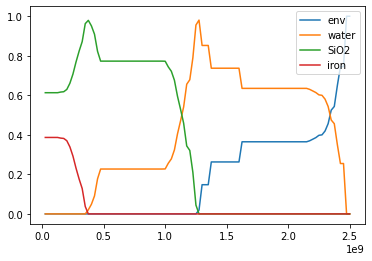

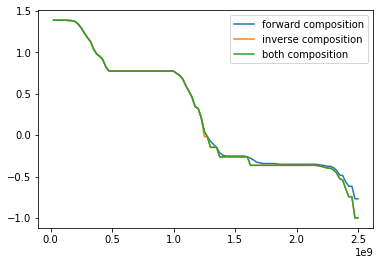

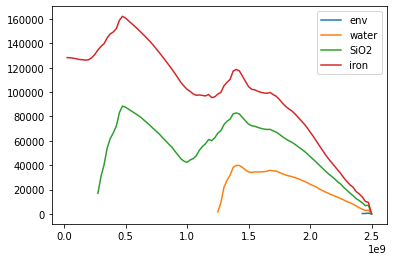

In [9]:
best_model(0.709555096, max_temp=59779, full_model=True)